In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score

# Predicting whether an order should be sent to a technical approver

**Goal** is to predict if an order needs technical approval or not

In [2]:
### Data Exploration

In [3]:
# load data
path = '/Users/liamhettinger/Documents/Portfolio_work/Data/orders_with_predicted_value.csv'
orders = pd.read_csv(path)
orders.head(5) 

,tech_approval_required,requester_id,role,product,quantity,price,total
0,0,E2300,tech,Desk,1,664,664
1,0,E2300,tech,Keyboard,9,649,5841
2,0,E2374,non-tech,Keyboard,1,821,821
3,1,E2374,non-tech,Desktop Computer,24,655,15720
4,0,E2327,non-tech,Desk,1,758,758


In [4]:
#target variable
orders.tech_approval_required.value_counts()

tech_approval_required
0    807
1    193
Name: count, dtype: int64

In [5]:
#null values in the dataframe
orders.isnull().sum()

tech_approval_required    0
requester_id              0
role                      0
product                   0
quantity                  0
price                     0
total                     0
dtype: int64

In [6]:
#feature datatypes
orders.dtypes

tech_approval_required     int64
requester_id              object
role                      object
product                   object
quantity                   int64
price                      int64
total                      int64
dtype: object

In [7]:
#defining X and Y variable
X = orders.drop('tech_approval_required', axis = 1)
y = orders.tech_approval_required

In [8]:
#traing test split
X_train,X_test,y_train,y_test = train_test_split(X,y)

**Part 3:** build a classification pipeline (feature preprocessor + Classification Tree)

In [9]:
cat = ['requester_id', 'role', 'product']
cat_processor = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')) #1 of n categorical variable conversion
])

In [10]:
num = ['quantity','price', 'total']
num_processor = Pipeline(steps=[
    ('scaler', StandardScaler()) #normalizes data
])

In [11]:
processor = ColumnTransformer(transformers=[
    ('cat_processor',cat_processor,cat),
    ('num_processor',num_processor,num)
])

In [12]:
pipe = Pipeline(steps = [
    ('processor', processor),
    ('tree_clf', DecisionTreeClassifier()) #model
])

In [13]:
#defining parameters dictionary
params_dict = {'tree_clf__max_depth' : range(1,100)}

In [14]:
#defining grid search and tuning hyperparameters
grid = GridSearchCV(pipe, params_dict, cv = 10, scoring = 'neg_root_mean_squared_error', n_jobs=-1, verbose=True)

In [15]:
#fitting model
grid.fit(X_train,y_train)

Fitting 10 folds for each of 99 candidates, totalling 990 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('cat_processor',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['requester_id',
                                                                          'role',
                                                                          'product']),
                                                                        ('num_processor',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['quantity',
                                                                          'price',
                                                                          'total'])])),
                                       ('tree_clf', DecisionTreeClassifier())]),
             n_jobs=-1, param_grid={'tree_clf__max_depth': range(1, 100)},
             scoring='neg_root_mean_squared_error', verbose=True)

In [16]:
#predicting both y_train and y_test
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

In [17]:
#Finding be tree depth
grid.best_params_

{'tree_clf__max_depth': 3}

### Visualizing tree

In [18]:
#listing model features
cat_features = list(grid.best_estimator_['processor'].named_transformers_['cat_processor']['encoder'].get_feature_names_out(cat))
feature_names = num+cat_features

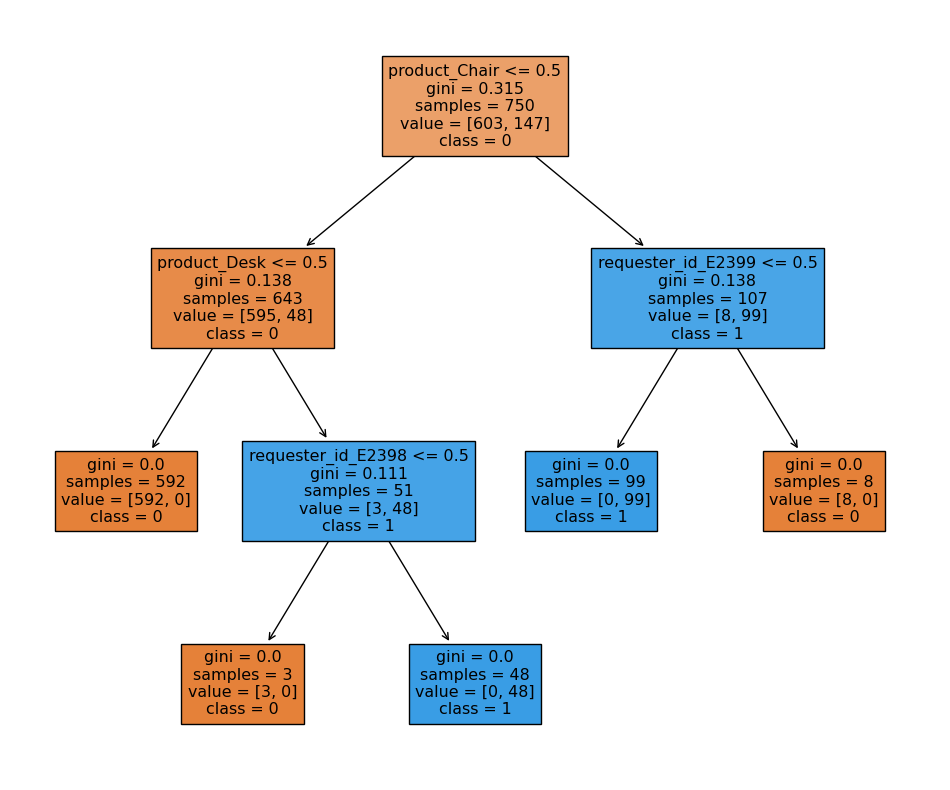

In [19]:
#plot tree
plt.figure(figsize=(12,10))
plot_tree(grid.best_estimator_['tree_clf'], feature_names=feature_names, class_names =['0','1'], filled=True)
plt.show()

In [20]:
#confusion matrix
confusion_matrix(y_test,y_test_pred)

array([[204,   0],
       [  0,  46]])

In [21]:
#accuracy score
accuracy_score(y_test,y_test_pred)

1.0